# 单变量

### BPA

In [24]:
import pandas as pd
import statsmodels.api as sm

# 读取数据
file_path = 'BPA.xlsx'
df = pd.read_excel(file_path)

# 设置列名
city_col = df.columns[2]
concentration_col = df.columns[3]
indicators = df.columns[4:]

# 结果列表
results = []

for indicator in indicators:
    # 提取需要的两列并转换为数值型（非数字变 NaN）
    sub_df = df[[concentration_col, indicator]].copy()
    sub_df[concentration_col] = pd.to_numeric(sub_df[concentration_col], errors='coerce')
    sub_df[indicator] = pd.to_numeric(sub_df[indicator], errors='coerce')
    
    # 丢弃缺失值
    sub_df = sub_df.dropna()

    # 样本量不足时跳过
    if len(sub_df) < 5:
        results.append((indicator, len(sub_df), None, None, None))
        continue

    # 回归建模
    X = sm.add_constant(sub_df[indicator])
    y = sub_df[concentration_col]
    model = sm.OLS(y, X).fit()

    # 存储结果
    r2 = model.rsquared
    p_val = model.pvalues[1]
    coef = model.params[1]
    results.append((indicator, len(sub_df), coef, r2, p_val))

# 结果表
results_df = pd.DataFrame(results, columns=['指标', '样本数', '回归系数', 'R²', 'p值'])
significant_df = results_df[(results_df['p值'] < 0.2) ]
                            #& (results_df['R²'] > 0.7)]

# 显示输出
print("【所有指标回归结果】：")
print(results_df)

print("\n【显著指标（p < 0.1）】：")
print(significant_df)

results_df.to_excel("回归结果总表_BPA.xlsx", index=False)


【所有指标回归结果】：
                  指标  样本数          回归系数        R²        p值
0           地区生产总值万元   66  3.692203e-07  0.000357  0.880241
1          第一产业增加值万元   66 -1.188447e-04  0.020198  0.254991
2          第二产业增加值万元   66  2.391579e-06  0.001605  0.749437
3          第三产业增加值万元   66  3.624839e-07  0.000165  0.918345
4      第一产业增加值占GDP比重   66 -3.108522e+01  0.021584  0.239136
..               ...  ...           ...       ...       ...
170        失业保险参保人数人   65  1.016892e-04  0.025760  0.201536
171    提供住宿的社会工作机构数个   61 -1.477105e+00  0.020489  0.271110
172           养老机构数个   62 -1.294552e+00  0.017553  0.304648
173  提供住宿的社会工作机构床位数张   60 -3.948029e-03  0.009632  0.455659
174         养老机构床位数张   61 -4.263697e-03  0.010081  0.441365

[175 rows x 5 columns]

【显著指标（p < 0.1）】：
                  指标  样本数        回归系数        R²            p值
21       第二产业从业人员数万人   66    6.758469  0.094768  1.191892e-02
24        第二产业从业人员比重   66   21.768251  0.072438  2.887094e-02
25        第三产业从业人员比重   66  -17.985685  0

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# 1. 选取你要做PCA的所有指标列
indicator_cols = ['工业废水排放量万吨', '工业氮氧化物排放量吨', '生活垃圾无害化处理率', '规模以上工业企业数个', '生活污水处理率', '第二产业从业人员比重']  # 示例，替换成你实际的列名
indicator_df = df[indicator_cols].copy()

# 2. 删除指标中含有缺失值的行（PCA要求完整数据）
indicator_df = indicator_df.dropna()

# 3. 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(indicator_df)

# 4. 进行PCA分析
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 5. 查看每个主成分的方差解释比例（贡献率）
explained_variance = pca.explained_variance_ratio_

# 6. 查看每个原始指标在每个主成分上的权重（即主成分载荷）
loadings = pca.components_.T  # shape: (n_features, n_components)

# 7. 计算每个指标对前n个主成分的总贡献（可选前2或前3个主成分）
n_components = 3
indicator_contributions = np.sum(np.abs(loadings[:, :n_components]) * explained_variance[:n_components], axis=1)

# 8. 汇总成DataFrame，排序
importance_df = pd.DataFrame({
    '指标': indicator_cols,
    '重要性得分': indicator_contributions
})
importance_df = importance_df.sort_values(by='重要性得分', ascending=False)

# 9. 显示结果
print("各指标在前%d个主成分中的综合重要性：" % n_components)
print(importance_df)


各指标在前3个主成分中的综合重要性：
           指标     重要性得分
0   工业废水排放量万吨  0.311687
3  规模以上工业企业数个  0.303622
4     生活污水处理率  0.297569
2  生活垃圾无害化处理率  0.256933
5  第二产业从业人员比重  0.244869
1  工业氮氧化物排放量吨  0.244858


In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 2. 选择因变量（浓度列）和自变量（多个指标）
dependent_var = 'Concentration'  # 替换成你数据中实际的浓度列名
independent_vars = ['工业废水排放量万吨', '工业氮氧化物排放量吨', '生活垃圾无害化处理率', '规模以上工业企业数个', '生活污水处理率', '第二产业从业人员比重']  

# 3. 提取完整数据（只删除有缺失值的行）
reg_df = df[[dependent_var] + independent_vars].dropna()

# 4. 标准化自变量（可选，但推荐，如果指标量纲差异较大）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(reg_df[independent_vars])

# 5. 添加常数项（截距项）
X = sm.add_constant(X_scaled)
y = reg_df[dependent_var]

# 6. 建立模型并拟合
model = sm.OLS(y, X).fit()

# 7. 输出回归结果
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          Concentration   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     2.210
Date:                Sun, 25 May 2025   Prob (F-statistic):             0.0553
Time:                        15:49:59   Log-Likelihood:                -535.46
No. Observations:                  63   AIC:                             1085.
Df Residuals:                      56   BIC:                             1100.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        268.4435    158.826      1.690      0.0

随机森林回归模型评估：
MSE: 31025.2773, R²: -0.8918


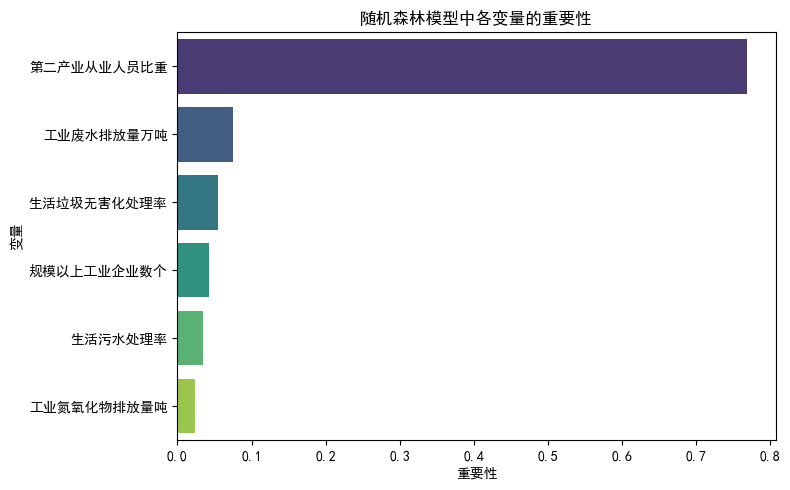

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from pylab import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 设置变量
dependent_var = 'Concentration'
independent_vars = ['工业废水排放量万吨', '工业氮氧化物排放量吨', '生活垃圾无害化处理率', '规模以上工业企业数个', '生活污水处理率', '第二产业从业人员比重']  

# 2. 预处理数据
rf_df = df[[dependent_var] + independent_vars].dropna()
rf_df = rf_df.apply(pd.to_numeric, errors='coerce').dropna()

X = rf_df[independent_vars]
y = rf_df[dependent_var]

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 建立随机森林模型并训练
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. 模型预测与评估
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"随机森林回归模型评估：\nMSE: {mse:.4f}, R²: {r2:.4f}")
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
# 6. 可视化：变量重要性
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    '变量': independent_vars,
    '重要性': importances
}).sort_values(by='重要性', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='重要性', y='变量', palette='viridis')
plt.title('随机森林模型中各变量的重要性')
plt.tight_layout()
plt.show()


### OP

In [26]:
import pandas as pd
import statsmodels.api as sm

# 读取数据
file_path = 'OP.xlsx'
df = pd.read_excel(file_path)

# 设置列名
city_col = df.columns[2]
concentration_col = df.columns[3]
indicators = df.columns[4:]

# 结果列表
results = []

for indicator in indicators:
    # 提取需要的两列并转换为数值型（非数字变 NaN）
    sub_df = df[[concentration_col, indicator]].copy()
    sub_df[concentration_col] = pd.to_numeric(sub_df[concentration_col], errors='coerce')
    sub_df[indicator] = pd.to_numeric(sub_df[indicator], errors='coerce')
    
    # 丢弃缺失值
    sub_df = sub_df.dropna()

    # 样本量不足时跳过
    if len(sub_df) < 5:
        results.append((indicator, len(sub_df), None, None, None))
        continue

    # 回归建模
    X = sm.add_constant(sub_df[indicator])
    y = sub_df[concentration_col]
    model = sm.OLS(y, X).fit()

    # 存储结果
    r2 = model.rsquared
    p_val = model.pvalues[1]
    coef = model.params[1]
    results.append((indicator, len(sub_df), coef, r2, p_val))

# 结果表
results_df = pd.DataFrame(results, columns=['指标', '样本数', '回归系数', 'R²', 'p值'])
significant_df = results_df[(results_df['p值'] < 0.05) ]
                            #& (results_df['R²'] > 0.7)]

# 显示输出
print("【所有指标回归结果】：")
print(results_df)

print("\n【显著指标（p < 0.05）】：")
print(significant_df)

# 导出
results_df.to_excel("回归结果总表_OP.xlsx", index=False)



【所有指标回归结果】：
                  指标  样本数       回归系数        R²        p值
0           地区生产总值万元   48   0.000002  0.198546  0.001505
1          第一产业增加值万元   48   0.000036  0.092817  0.035253
2          第二产业增加值万元   48   0.000006  0.334243  0.000017
3          第三产业增加值万元   48   0.000002  0.120878  0.015463
4      第一产业增加值占GDP比重   48 -12.602423  0.135749  0.009975
..               ...  ...        ...       ...       ...
169        失业保险参保人数人   47   0.000042  0.083645  0.048642
170    提供住宿的社会工作机构数个   43   0.578556  0.077827  0.070047
171           养老机构数个   44   0.242120  0.015647  0.418496
172  提供住宿的社会工作机构床位数张   42   0.003697  0.093760  0.048588
173         养老机构床位数张   43   0.003433  0.075743  0.074067

[174 rows x 5 columns]

【显著指标（p < 0.05）】：
                  指标  样本数       回归系数        R²        p值
0           地区生产总值万元   48   0.000002  0.198546  0.001505
1          第一产业增加值万元   48   0.000036  0.092817  0.035253
2          第二产业增加值万元   48   0.000006  0.334243  0.000017
3          第三产业增加值万元   48   0.000

In [26]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 2. 选择因变量（浓度列）和自变量（多个指标）
dependent_var = concentration_col # 替换成你数据中实际的浓度列名
independent_vars = ['工业废水排放量万吨', '工业氮氧化物排放量吨', '生活垃圾无害化处理率', '规模以上工业企业数个', '生活污水处理率', '第二产业从业人员比重','第二产业增加值万元']  

# 3. 提取完整数据（只删除有缺失值的行）
reg_df = df[[dependent_var] + independent_vars].dropna()

# 4. 标准化自变量（可选，但推荐，如果指标量纲差异较大）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(reg_df[independent_vars])

# 5. 添加常数项（截距项）
X = sm.add_constant(X_scaled)
y = reg_df[dependent_var]

# 6. 建立模型并拟合
model = sm.OLS(y, X).fit()

# 7. 输出回归结果
print(model.summary())


                               OLS Regression Results                               
Dep. Variable:     Mean Concentration（ng/L）   R-squared:                       0.478
Model:                                  OLS   Adj. R-squared:                  0.382
Method:                       Least Squares   F-statistic:                     4.976
Date:                      Sun, 25 May 2025   Prob (F-statistic):           0.000458
Time:                              16:06:54   Log-Likelihood:                -293.57
No. Observations:                        46   AIC:                             603.1
Df Residuals:                            38   BIC:                             617.8
Df Model:                                 7                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

随机森林回归模型评估：
MSE: 26768.0724, R²: -0.0911


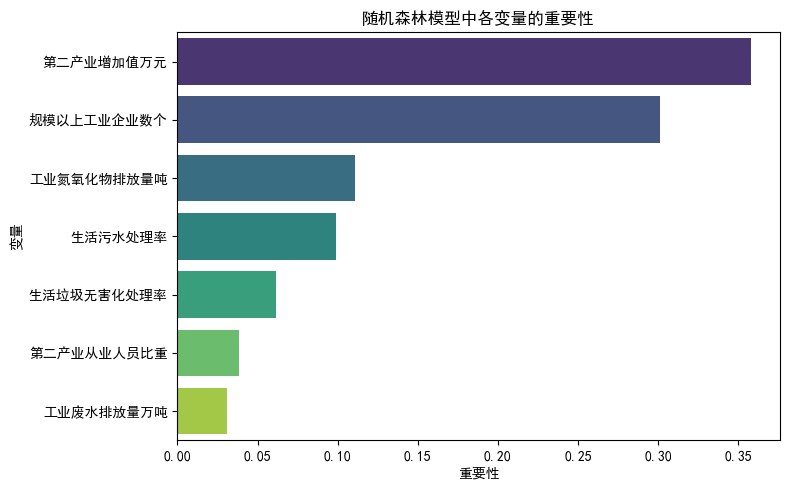

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 设置变量
dependent_var = concentration_col # 替换成你数据中实际的浓度列名
independent_vars = ['工业废水排放量万吨', '工业氮氧化物排放量吨', '生活垃圾无害化处理率', '规模以上工业企业数个', '生活污水处理率', '第二产业从业人员比重','第二产业增加值万元']  

# 2. 预处理数据
rf_df = df[[dependent_var] + independent_vars].dropna()
rf_df = rf_df.apply(pd.to_numeric, errors='coerce').dropna()

X = rf_df[independent_vars]
y = rf_df[dependent_var]

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 建立随机森林模型并训练
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. 模型预测与评估
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"随机森林回归模型评估：\nMSE: {mse:.4f}, R²: {r2:.4f}")

# 6. 可视化：变量重要性
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    '变量': independent_vars,
    '重要性': importances
}).sort_values(by='重要性', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='重要性', y='变量', palette='viridis')
plt.title('随机森林模型中各变量的重要性')
plt.tight_layout()
plt.show()


### E1

In [28]:
import pandas as pd
import statsmodels.api as sm

# 读取数据
file_path = 'E1.xlsx'
df = pd.read_excel(file_path)

# 设置列名
city_col = df.columns[2]
concentration_col = df.columns[3]
indicators = df.columns[4:]

# 结果列表
results = []

for indicator in indicators:
    # 提取需要的两列并转换为数值型（非数字变 NaN）
    sub_df = df[[concentration_col, indicator]].copy()
    sub_df[concentration_col] = pd.to_numeric(sub_df[concentration_col], errors='coerce')
    sub_df[indicator] = pd.to_numeric(sub_df[indicator], errors='coerce')
    
    # 丢弃缺失值
    sub_df = sub_df.dropna()

    # 样本量不足时跳过
    if len(sub_df) < 5:
        results.append((indicator, len(sub_df), None, None, None))
        continue

    # 回归建模
    X = sm.add_constant(sub_df[indicator])
    y = sub_df[concentration_col]
    model = sm.OLS(y, X).fit()

    # 存储结果
    r2 = model.rsquared
    p_val = model.pvalues[1]
    coef = model.params[1]
    results.append((indicator, len(sub_df), coef, r2, p_val))

# 结果表
results_df = pd.DataFrame(results, columns=['指标', '样本数', '回归系数', 'R²', 'p值'])
significant_df = results_df[(results_df['p值'] < 0.1) ]#& (results_df['R²'] > 0.7)]

# 显示输出
print("【所有指标回归结果】：")
print(results_df)

print("\n【显著指标（p < 0.1）】：")
print(significant_df)

results_df.to_excel("回归结果总表_E1.xlsx", index=False)


【所有指标回归结果】：
                  指标  样本数          回归系数        R²        p值
0           地区生产总值万元   40  3.673030e-08  0.141173  0.016883
1          第一产业增加值万元   40 -4.966088e-07  0.019415  0.391171
2          第二产业增加值万元   40  1.632970e-07  0.263446  0.000707
3          第三产业增加值万元   40  4.389823e-08  0.099681  0.047191
4      第一产业增加值占GDP比重   40 -2.872071e-01  0.117536  0.030339
..               ...  ...           ...       ...       ...
168        失业保险参保人数人   39  1.682822e-06  0.219217  0.002648
169    提供住宿的社会工作机构数个   36  2.279660e-02  0.240287  0.002406
170           养老机构数个   37  2.112615e-02  0.292257  0.000552
171  提供住宿的社会工作机构床位数张   34  1.369186e-04  0.485774  0.000005
172         养老机构床位数张   35  1.395904e-04  0.471769  0.000005

[173 rows x 5 columns]

【显著指标（p < 0.1）】：
                  指标  样本数          回归系数        R²        p值
0           地区生产总值万元   40  3.673030e-08  0.141173  0.016883
2          第二产业增加值万元   40  1.632970e-07  0.263446  0.000707
3          第三产业增加值万元   40  4.389823e-08  0.099

In [38]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 2. 设置变量名
dependent_var = df.columns[3]  # 请替换为你的目标列名
independent_vars = ['工业废水排放量万吨', '工业氮氧化物排放量吨',  '规模以上工业企业数个', '生活污水处理率', '第二产业从业人员比重','第二产业增加值万元','第三产业从业人员比重']  # 替换为你的列名

# 3. 筛选出需要的列并去除缺失值
reg_df = df[[dependent_var] + independent_vars].dropna()

# 4. 强制转换为数值类型，防止 object 类型
reg_df = reg_df.apply(pd.to_numeric, errors='coerce')

# 再次 drop 掉转换失败后的缺失值
reg_df = reg_df.dropna()

# 5. 标准化自变量
scaler = StandardScaler()
X_scaled = scaler.fit_transform(reg_df[independent_vars])

# 6. 构造 X 和 y
X = sm.add_constant(X_scaled)
y = reg_df[dependent_var].values  # 明确转为数组避免 object 问题

# 7. 拟合模型
model = sm.OLS(y, X).fit()

# 8. 打印结果
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     4.754
Date:                Sun, 25 May 2025   Prob (F-statistic):            0.00118
Time:                        16:18:50   Log-Likelihood:                -101.51
No. Observations:                  37   AIC:                             219.0
Df Residuals:                      29   BIC:                             231.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1938      0.698      4.573      0.0

随机森林回归模型评估：
MSE: 106.3363, R²: -0.1055


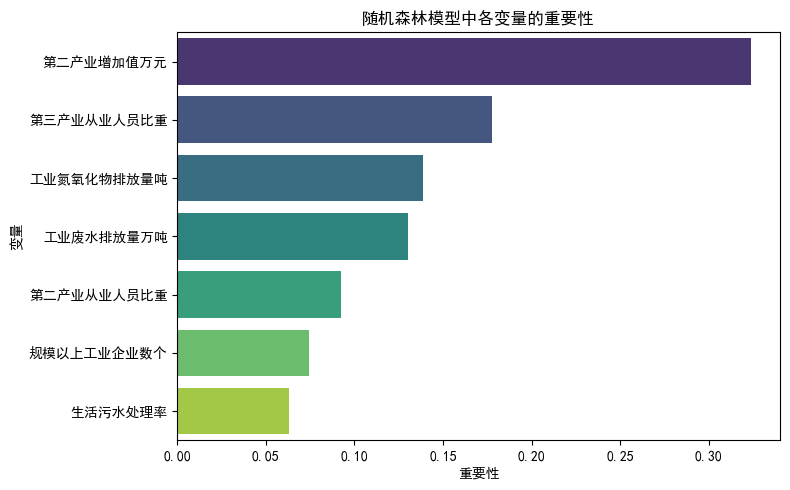

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 设置变量
dependent_var = df.columns[3]  # 请替换为你的目标列名
independent_vars = ['工业废水排放量万吨', '工业氮氧化物排放量吨',  '规模以上工业企业数个', '生活污水处理率', '第二产业从业人员比重','第二产业增加值万元','第三产业从业人员比重']  # 替换为你的列名

# 2. 预处理数据
rf_df = df[[dependent_var] + independent_vars].dropna()
rf_df = rf_df.apply(pd.to_numeric, errors='coerce').dropna()

X = rf_df[independent_vars]
y = rf_df[dependent_var]

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 建立随机森林模型并训练
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. 模型预测与评估
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"随机森林回归模型评估：\nMSE: {mse:.4f}, R²: {r2:.4f}")

# 6. 可视化：变量重要性
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    '变量': independent_vars,
    '重要性': importances
}).sort_values(by='重要性', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='重要性', y='变量', palette='viridis')
plt.title('随机森林模型中各变量的重要性')
plt.tight_layout()
plt.show()


### NP

In [30]:
import pandas as pd
import statsmodels.api as sm

# 读取数据
file_path = 'NP.xlsx'
df = pd.read_excel(file_path)

# 设置列名
city_col = df.columns[2]
concentration_col = df.columns[3]
indicators = df.columns[4:]

# 结果列表
results = []

for indicator in indicators:
    # 提取需要的两列并转换为数值型（非数字变 NaN）
    sub_df = df[[concentration_col, indicator]].copy()
    sub_df[concentration_col] = pd.to_numeric(sub_df[concentration_col], errors='coerce')
    sub_df[indicator] = pd.to_numeric(sub_df[indicator], errors='coerce')
    
    # 丢弃缺失值
    sub_df = sub_df.dropna()

    # 样本量不足时跳过
    if len(sub_df) < 5:
        results.append((indicator, len(sub_df), None, None, None))
        continue

    # 回归建模
    X = sm.add_constant(sub_df[indicator])
    y = sub_df[concentration_col]
    model = sm.OLS(y, X).fit()

    # 存储结果
    r2 = model.rsquared
    p_val = model.pvalues[1]
    coef = model.params[1]
    results.append((indicator, len(sub_df), coef, r2, p_val))

# 结果表
results_df = pd.DataFrame(results, columns=['指标', '样本数', '回归系数', 'R²', 'p值'])
significant_df = results_df[(results_df['p值'] < 0.1) ]#& (results_df['R²'] > 0.7)]

# 显示输出
print("【所有指标回归结果】：")
print(results_df)

print("\n【显著指标（p < 0.1）】：")
print(significant_df)

results_df.to_excel("回归结果总表_NP.xlsx", index=False)

【所有指标回归结果】：
                  指标  样本数          回归系数        R²            p值
0          第一产业增加值万元   55  7.206012e+00  0.043384  1.270070e-01
1          第二产业增加值万元   55  2.655925e+00  0.908548  3.383642e-29
2          第三产业增加值万元   55  1.491948e+00  0.971761  9.799335e-43
3      第一产业增加值占GDP比重   55 -5.044861e+06  0.285992  2.598942e-05
4      第二产业增加值占GDP比重   55 -2.921509e+06  0.241581  1.385957e-04
..               ...  ...           ...       ...           ...
167        失业保险参保人数人   54  3.566456e+01  0.869726  1.140849e-24
168    提供住宿的社会工作机构数个   50  2.154176e+05  0.181633  2.028815e-03
169           养老机构数个   51  1.906261e+05  0.160795  3.544094e-03
170  提供住宿的社会工作机构床位数张   49  1.347464e+03  0.385481  1.940839e-06
171         养老机构床位数张   50  1.343842e+03  0.360069  4.109191e-06

[172 rows x 5 columns]

【显著指标（p < 0.1）】：
                  指标  样本数          回归系数        R²            p值
1          第二产业增加值万元   55  2.655925e+00  0.908548  3.383642e-29
2          第三产业增加值万元   55  1.491948e+00  0.971761 

In [31]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 2. 设置变量名
dependent_var = df.columns[3]  # 请替换为你的目标列名
independent_vars = ['工业废水排放量万吨', '工业氮氧化物排放量吨',  '规模以上工业企业数个', '生活污水处理率', '第三产业增加值万元','第二产业增加值万元','社会消费品零售总额万元']  # 替换为你的列名

# 3. 筛选出需要的列并去除缺失值
reg_df = df[[dependent_var] + independent_vars].dropna()

# 4. 强制转换为数值类型，防止 object 类型
reg_df = reg_df.apply(pd.to_numeric, errors='coerce')

# 再次 drop 掉转换失败后的缺失值
reg_df = reg_df.dropna()

# 5. 标准化自变量
scaler = StandardScaler()
X_scaled = scaler.fit_transform(reg_df[independent_vars])

# 6. 构造 X 和 y
X = sm.add_constant(X_scaled)
y = reg_df[dependent_var].values  # 明确转为数组避免 object 问题

# 7. 拟合模型
model = sm.OLS(y, X).fit()

# 8. 打印结果
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.356e+04
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.39e-72
Time:                        18:24:22   Log-Likelihood:                -817.97
No. Observations:                  53   AIC:                             1652.
Df Residuals:                      45   BIC:                             1668.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.585e+07   1.82e+05    252.048      0.0

随机森林回归模型评估：
MSE: 20638867941272.7031, R²: 0.9770


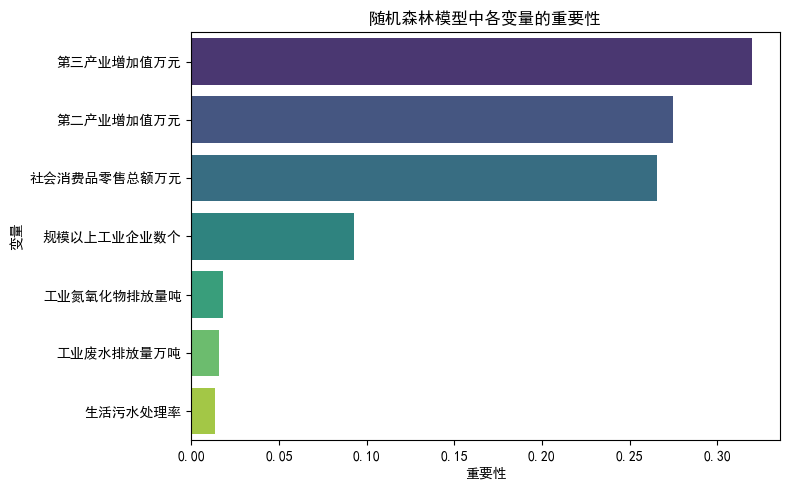

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 设置变量
dependent_var = df.columns[3]  # 请替换为你的目标列名
independent_vars = ['工业废水排放量万吨', '工业氮氧化物排放量吨',  '规模以上工业企业数个', '生活污水处理率', '第三产业增加值万元','第二产业增加值万元','社会消费品零售总额万元']  # 替换为你的列名

# 2. 预处理数据
rf_df = df[[dependent_var] + independent_vars].dropna()
rf_df = rf_df.apply(pd.to_numeric, errors='coerce').dropna()

X = rf_df[independent_vars]
y = rf_df[dependent_var]

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 建立随机森林模型并训练
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. 模型预测与评估
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"随机森林回归模型评估：\nMSE: {mse:.4f}, R²: {r2:.4f}")

# 6. 可视化：变量重要性
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    '变量': independent_vars,
    '重要性': importances
}).sort_values(by='重要性', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='重要性', y='变量', palette='viridis')
plt.title('随机森林模型中各变量的重要性')
plt.tight_layout()
plt.show()


### BBP

In [33]:
import pandas as pd
import statsmodels.api as sm

# 读取数据
file_path = 'BBP-final.xlsx'
df = pd.read_excel(file_path)

# 设置列名
city_col = df.columns[1]
concentration_col = df.columns[2]
indicators = df.columns[3:]

# 结果列表
results = []

for indicator in indicators:
    # 提取需要的两列并转换为数值型（非数字变 NaN）
    sub_df = df[[concentration_col, indicator]].copy()
    sub_df[concentration_col] = pd.to_numeric(sub_df[concentration_col], errors='coerce')
    sub_df[indicator] = pd.to_numeric(sub_df[indicator], errors='coerce')
    
    # 丢弃缺失值
    sub_df = sub_df.dropna()

    # 样本量不足时跳过
    if len(sub_df) < 5:
        results.append((indicator, len(sub_df), None, None, None))
        continue

    # 回归建模
    X = sm.add_constant(sub_df[indicator])
    y = sub_df[concentration_col]
    model = sm.OLS(y, X).fit()

    # 存储结果
    r2 = model.rsquared
    p_val = model.pvalues[1]
    coef = model.params[1]
    results.append((indicator, len(sub_df), coef, r2, p_val))

# 结果表
results_df = pd.DataFrame(results, columns=['指标', '样本数', '回归系数', 'R²', 'p值'])
significant_df = results_df[(results_df['p值'] < 0.1) ]#& (results_df['R²'] > 0.7)]

# 显示输出
print("【所有指标回归结果】：")
print(results_df)

print("\n【显著指标（p < 0.1）】：")
print(significant_df)

results_df.to_excel("回归结果总表_BBP.xlsx", index=False)

【所有指标回归结果】：
                  指标  样本数          回归系数        R²        p值
0           地区生产总值万元   41 -2.032177e-07  0.007892  0.580724
1          第一产业增加值万元   41 -1.088459e-05  0.021580  0.359389
2          第二产业增加值万元   41 -6.834297e-07  0.010250  0.528793
3          第三产业增加值万元   41 -2.532335e-07  0.005534  0.643914
4      第一产业增加值占GDP比重   41 -6.056670e+00  0.026905  0.305471
..               ...  ...           ...       ...       ...
180        失业保险参保人数人   41 -3.242068e-06  0.001975  0.782630
181    提供住宿的社会工作机构数个   38 -3.256468e-02  0.008535  0.581176
182           养老机构数个   40 -3.127838e-02  0.007864  0.586351
183  提供住宿的社会工作机构床位数张   39 -7.396203e-04  0.017942  0.416238
184         养老机构床位数张   41 -7.751283e-04  0.018917  0.391158

[185 rows x 5 columns]

【显著指标（p < 0.1）】：
                     指标  样本数        回归系数        R²            p值
14                死亡人口人   41    0.001452  0.254101  7.786822e-04
27           采掘业从业人员数万人   40  103.006289  0.797829  9.208663e-15
48         社会服务业从业人员数万人   41   

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 2. 设置变量名
dependent_var = df.columns[2]  # 请替换为你的目标列名
independent_vars = ['工业二氧化硫排放量吨', '死亡人口人',  '粮食产量万吨','地区生产总值万元','细颗粒物PM25年平均浓度微克立方米', '社会服务业从业人员数万人', '一般工业固体废物综合利用率','养老机构数个','普通高等学校学校数所']  # 替换为你的列名

# 3. 筛选出需要的列并去除缺失值
reg_df = df[[dependent_var] + independent_vars].dropna()

# 4. 强制转换为数值类型，防止 object 类型
reg_df = reg_df.apply(pd.to_numeric, errors='coerce')

# 再次 drop 掉转换失败后的缺失值
reg_df = reg_df.dropna()

# 5. 标准化自变量
scaler = StandardScaler()
X_scaled = scaler.fit_transform(reg_df[independent_vars])

# 6. 构造 X 和 y
X = sm.add_constant(X_scaled)
y = reg_df[dependent_var].values  # 明确转为数组避免 object 问题

# 7. 拟合模型
model = sm.OLS(y, X).fit()

# 8. 打印结果
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     4.947
Date:                Mon, 26 May 2025   Prob (F-statistic):           0.000713
Time:                        12:40:24   Log-Likelihood:                -252.93
No. Observations:                  40   AIC:                             521.9
Df Residuals:                      32   BIC:                             535.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.2451     23.840      1.478      0.1

随机森林回归模型评估：
MSE: 4078.2097, R²: -378.3259


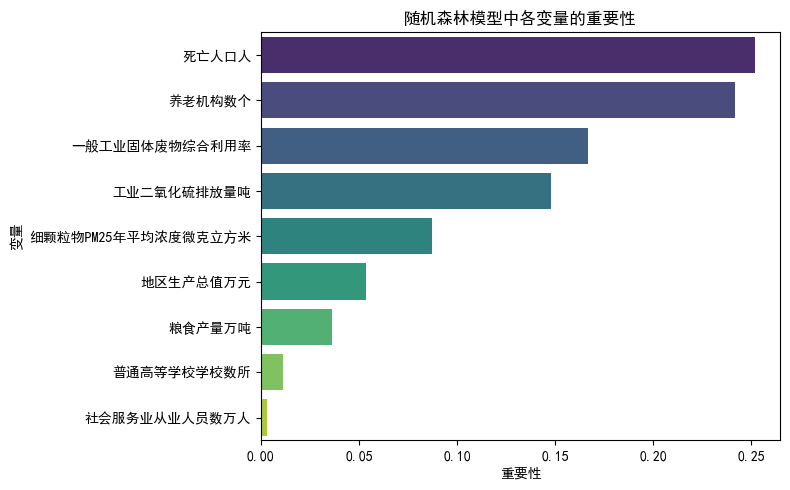

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 设置变量
dependent_var = df.columns[2]  # 请替换为你的目标列名
independent_vars = ['工业二氧化硫排放量吨', '死亡人口人',  '粮食产量万吨','地区生产总值万元','细颗粒物PM25年平均浓度微克立方米', '社会服务业从业人员数万人', '一般工业固体废物综合利用率','养老机构数个','普通高等学校学校数所']  # 替换为你的列名

# 2. 预处理数据
rf_df = df[[dependent_var] + independent_vars].dropna()
rf_df = rf_df.apply(pd.to_numeric, errors='coerce').dropna()

X = rf_df[independent_vars]
y = rf_df[dependent_var]

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 建立随机森林模型并训练
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. 模型预测与评估
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"随机森林回归模型评估：\nMSE: {mse:.4f}, R²: {r2:.4f}")

# 6. 可视化：变量重要性
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    '变量': independent_vars,
    '重要性': importances
}).sort_values(by='重要性', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='重要性', y='变量', palette='viridis')
plt.title('随机森林模型中各变量的重要性')
plt.tight_layout()
plt.show()


### DBP

In [35]:
import pandas as pd
import statsmodels.api as sm

# 读取数据
file_path = 'DBP-final.xlsx'
df = pd.read_excel(file_path)

# 设置列名
city_col = df.columns[1]
concentration_col = df.columns[6]
indicators = df.columns[13:]

# 结果列表
results = []

for indicator in indicators:
    # 提取需要的两列并转换为数值型（非数字变 NaN）
    sub_df = df[[concentration_col, indicator]].copy()
    sub_df[concentration_col] = pd.to_numeric(sub_df[concentration_col], errors='coerce')
    sub_df[indicator] = pd.to_numeric(sub_df[indicator], errors='coerce')
    
    # 丢弃缺失值
    sub_df = sub_df.dropna()

    # 样本量不足时跳过
    if len(sub_df) < 5:
        results.append((indicator, len(sub_df), None, None, None))
        continue

    # 回归建模
    X = sm.add_constant(sub_df[indicator])
    y = sub_df[concentration_col]
    model = sm.OLS(y, X).fit()

    # 存储结果
    r2 = model.rsquared
    p_val = model.pvalues[1]
    coef = model.params[1]
    results.append((indicator, len(sub_df), coef, r2, p_val))

# 结果表
results_df = pd.DataFrame(results, columns=['指标', '样本数', '回归系数', 'R²', 'p值'])
significant_df = results_df[(results_df['p值'] < 0.1) ]#& (results_df['R²'] > 0.7)]

# 显示输出
print("【所有指标回归结果】：")
print(results_df)

print("\n【显著指标（p < 0.1）】：")
print(significant_df)

results_df.to_excel("回归结果总表_DBP.xlsx", index=False)

【所有指标回归结果】：
                  指标  样本数          回归系数        R²        p值
0           地区生产总值万元   70 -1.850937e-07  0.000137  0.923446
1          第一产业增加值万元   70 -6.636151e-05  0.014678  0.317753
2          第二产业增加值万元   70 -9.423659e-07  0.000394  0.870513
3          第三产业增加值万元   70 -5.449674e-08  0.000005  0.984673
4      第一产业增加值占GDP比重   70 -4.061737e+01  0.032930  0.132727
..               ...  ...           ...       ...       ...
201        失业保险参保人数人   70  2.000069e-05  0.001331  0.764285
202    提供住宿的社会工作机构数个   66 -2.557805e-01  0.008492  0.461792
203           养老机构数个   69 -2.443144e-01  0.007667  0.474331
204  提供住宿的社会工作机构床位数张   67 -4.424894e-03  0.008816  0.449792
205         养老机构床位数张   70 -4.659727e-03  0.009143  0.431051

[206 rows x 5 columns]

【显著指标（p < 0.1）】：
                     指标  样本数        回归系数        R²            p值
14                死亡人口人   70    0.009191  0.200954  9.954901e-05
29           采掘业从业人员数万人   69  749.893317  0.705600  1.861415e-19
47      地质勘察水利管理业从业人数万人   69  6

In [8]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 2. 设置变量名
dependent_var = df.columns[6]  # 请替换为你的目标列名
independent_vars = ['工业二氧化硫排放量吨', '死亡人口人',  '粮食产量万吨','地区生产总值万元','细颗粒物PM25年平均浓度微克立方米', '社会服务业从业人员数万人', '一般工业固体废物综合利用率','养老机构数个','普通高等学校学校数所']  # 替换为你的列名

# 3. 筛选出需要的列并去除缺失值
reg_df = df[[dependent_var] + independent_vars].dropna()

# 4. 强制转换为数值类型，防止 object 类型
reg_df = reg_df.apply(pd.to_numeric, errors='coerce')

# 再次 drop 掉转换失败后的缺失值
reg_df = reg_df.dropna()

# 5. 标准化自变量
scaler = StandardScaler()
X_scaled = scaler.fit_transform(reg_df[independent_vars])

# 6. 构造 X 和 y
X = sm.add_constant(X_scaled)
y = reg_df[dependent_var].values  # 明确转为数组避免 object 问题

# 7. 拟合模型
model = sm.OLS(y, X).fit()

# 8. 打印结果
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     4.577
Date:                Mon, 26 May 2025   Prob (F-statistic):           0.000139
Time:                        13:15:47   Log-Likelihood:                -560.39
No. Observations:                  68   AIC:                             1141.
Df Residuals:                      58   BIC:                             1163.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        478.5427    120.526      3.970      0.0

随机森林回归模型评估：
MSE: 6467034.1221, R²: -0.0115


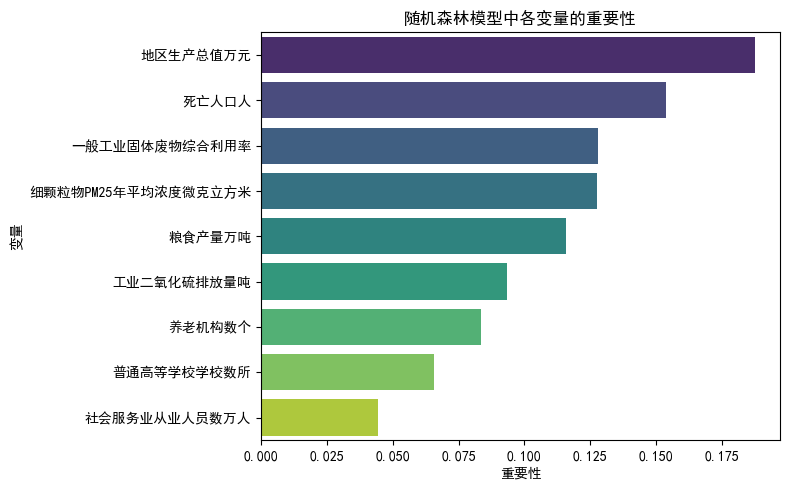

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 设置变量
dependent_var = df.columns[6]  # 请替换为你的目标列名
independent_vars = ['工业二氧化硫排放量吨', '死亡人口人',  '粮食产量万吨','地区生产总值万元','细颗粒物PM25年平均浓度微克立方米', '社会服务业从业人员数万人', '一般工业固体废物综合利用率','养老机构数个','普通高等学校学校数所']  # 替换为你的列名

# 2. 预处理数据
rf_df = df[[dependent_var] + independent_vars].dropna()
rf_df = rf_df.apply(pd.to_numeric, errors='coerce').dropna()

X = rf_df[independent_vars]
y = rf_df[dependent_var]

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 建立随机森林模型并训练
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. 模型预测与评估
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"随机森林回归模型评估：\nMSE: {mse:.4f}, R²: {r2:.4f}")

# 6. 可视化：变量重要性
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    '变量': independent_vars,
    '重要性': importances
}).sort_values(by='重要性', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='重要性', y='变量', palette='viridis')
plt.title('随机森林模型中各变量的重要性')
plt.tight_layout()
plt.show()


### DEHP

In [37]:
import pandas as pd
import statsmodels.api as sm

# 读取数据
file_path = 'DEHP.xlsx'
df = pd.read_excel(file_path)

# 设置列名
city_col = df.columns[1]
concentration_col = df.columns[6]
indicators = df.columns[13:]

# 结果列表
results = []

for indicator in indicators:
    # 提取需要的两列并转换为数值型（非数字变 NaN）
    sub_df = df[[concentration_col, indicator]].copy()
    sub_df[concentration_col] = pd.to_numeric(sub_df[concentration_col], errors='coerce')
    sub_df[indicator] = pd.to_numeric(sub_df[indicator], errors='coerce')
    
    # 丢弃缺失值
    sub_df = sub_df.dropna()

    # 样本量不足时跳过
    if len(sub_df) < 5:
        results.append((indicator, len(sub_df), None, None, None))
        continue

    # 回归建模
    X = sm.add_constant(sub_df[indicator])
    y = sub_df[concentration_col]
    model = sm.OLS(y, X).fit()

    # 存储结果
    r2 = model.rsquared
    p_val = model.pvalues[1]
    coef = model.params[1]
    results.append((indicator, len(sub_df), coef, r2, p_val))

# 结果表
results_df = pd.DataFrame(results, columns=['指标', '样本数', '回归系数', 'R²', 'p值'])
significant_df = results_df[(results_df['p值'] < 0.1) ]#& (results_df['R²'] > 0.7)]

# 显示输出
print("【所有指标回归结果】：")
print(results_df)

print("\n【显著指标（p < 0.1）】：")
print(significant_df)

results_df.to_excel("回归结果总表_DEHP.xlsx", index=False)

【所有指标回归结果】：
                  指标  样本数        回归系数        R²        p值
0           地区生产总值万元   73   -0.000008  0.004345  0.579508
1          第一产业增加值万元   73   -0.000411  0.011879  0.358681
2          第二产业增加值万元   73   -0.000024  0.004684  0.565062
3          第三产业增加值万元   73   -0.000010  0.003448  0.621666
4      第一产业增加值占GDP比重   73 -152.162044  0.008180  0.446669
..               ...  ...         ...       ...       ...
201        失业保险参保人数人   73   -0.000117  0.000831  0.808674
202    提供住宿的社会工作机构数个   68    1.483450  0.004976  0.567589
203           养老机构数个   72    1.974897  0.008772  0.433908
204  提供住宿的社会工作机构床位数张   69    0.138607  0.196639  0.000136
205         养老机构床位数张   73    0.146335  0.212801  0.000040

[206 rows x 5 columns]

【显著指标（p < 0.1）】：
                     指标  样本数        回归系数        R²        p值
181          工业二氧化硫排放量吨   73    0.163568  0.087184  0.011211
187          工业氮氧化物排放量吨   72    0.162097  0.081734  0.014914
196  细颗粒物PM25年平均浓度微克立方米   73  166.666571  0.070220  0.023472
204   

In [10]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 2. 设置变量名
dependent_var = df.columns[6]  # 请替换为你的目标列名
independent_vars = ['工业二氧化硫排放量吨', '工业氮氧化物排放量吨',  '粮食产量万吨','地区生产总值万元','细颗粒物PM25年平均浓度微克立方米', '第二产业从业人员比重', '第三产业从业人员比重','养老机构数个','第二产业增加值占GDP比重']  # 替换为你的列名

# 3. 筛选出需要的列并去除缺失值
reg_df = df[[dependent_var] + independent_vars].dropna()

# 4. 强制转换为数值类型，防止 object 类型
reg_df = reg_df.apply(pd.to_numeric, errors='coerce')

# 再次 drop 掉转换失败后的缺失值
reg_df = reg_df.dropna()

# 5. 标准化自变量
scaler = StandardScaler()
X_scaled = scaler.fit_transform(reg_df[independent_vars])

# 6. 构造 X 和 y
X = sm.add_constant(X_scaled)
y = reg_df[dependent_var].values  # 明确转为数组避免 object 问题

# 7. 拟合模型
model = sm.OLS(y, X).fit()

# 8. 打印结果
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1.344
Date:                Mon, 26 May 2025   Prob (F-statistic):              0.234
Time:                        14:21:15   Log-Likelihood:                -740.63
No. Observations:                  71   AIC:                             1501.
Df Residuals:                      61   BIC:                             1524.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1989.1015   1050.458      1.894      0.0

随机森林回归模型评估：
MSE: 122982703.7907, R²: -3.8807


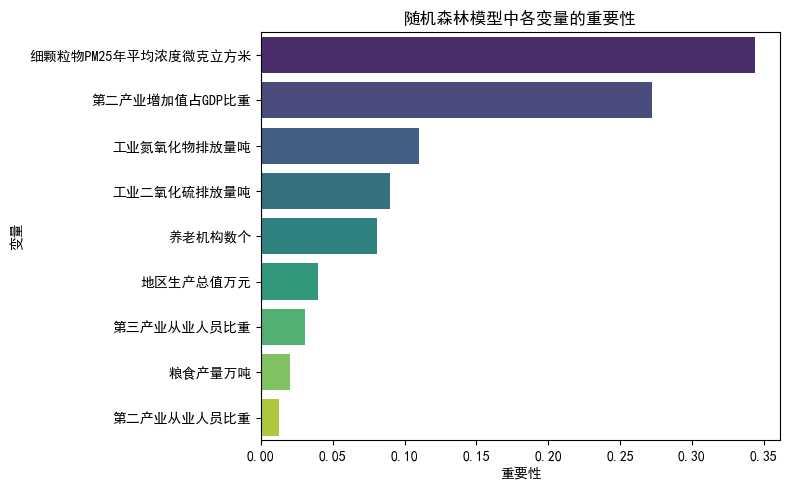

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 设置变量
dependent_var = df.columns[6]  # 请替换为你的目标列名
independent_vars = ['工业二氧化硫排放量吨', '工业氮氧化物排放量吨',  '粮食产量万吨','地区生产总值万元','细颗粒物PM25年平均浓度微克立方米', '第二产业从业人员比重', '第三产业从业人员比重','养老机构数个','第二产业增加值占GDP比重']  # 替换为你的列名

# 2. 预处理数据
rf_df = df[[dependent_var] + independent_vars].dropna()
rf_df = rf_df.apply(pd.to_numeric, errors='coerce').dropna()

X = rf_df[independent_vars]
y = rf_df[dependent_var]

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 建立随机森林模型并训练
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. 模型预测与评估
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"随机森林回归模型评估：\nMSE: {mse:.4f}, R²: {r2:.4f}")

# 6. 可视化：变量重要性
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    '变量': independent_vars,
    '重要性': importances
}).sort_values(by='重要性', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='重要性', y='变量', palette='viridis')
plt.title('随机森林模型中各变量的重要性')
plt.tight_layout()
plt.show()


### PFOA

In [39]:
import pandas as pd
import statsmodels.api as sm

# 读取数据
file_path = 'PFOA-final.xlsx'
df = pd.read_excel(file_path)

# 设置列名
city_col = df.columns[1]
concentration_col = df.columns[2]
indicators = df.columns[3:]

# 结果列表
results = []

for indicator in indicators:
    # 提取需要的两列并转换为数值型（非数字变 NaN）
    sub_df = df[[concentration_col, indicator]].copy()
    sub_df[concentration_col] = pd.to_numeric(sub_df[concentration_col], errors='coerce')
    sub_df[indicator] = pd.to_numeric(sub_df[indicator], errors='coerce')
    
    # 丢弃缺失值
    sub_df = sub_df.dropna()

    # 样本量不足时跳过
    if len(sub_df) < 5:
        results.append((indicator, len(sub_df), None, None, None))
        continue

    # 回归建模
    X = sm.add_constant(sub_df[indicator])
    y = sub_df[concentration_col]
    model = sm.OLS(y, X).fit()

    # 存储结果
    r2 = model.rsquared
    p_val = model.pvalues[1]
    coef = model.params[1]
    results.append((indicator, len(sub_df), coef, r2, p_val))

# 结果表
results_df = pd.DataFrame(results, columns=['指标', '样本数', '回归系数', 'R²', 'p值'])
significant_df = results_df[(results_df['p值'] < 0.1) ]#& (results_df['R²'] > 0.7)]

# 显示输出
print("【所有指标回归结果】：")
print(results_df)

print("\n【显著指标（p < 0.1）】：")
print(significant_df)

results_df.to_excel("回归结果总表_PFOA.xlsx", index=False)

【所有指标回归结果】：
                  指标  样本数          回归系数            R²        p值
0           地区生产总值万元   69 -1.868453e-08  4.236804e-04  0.866683
1          第一产业增加值万元   69 -2.726809e-06  4.904540e-03  0.567452
2          第二产业增加值万元   69 -5.824214e-08  4.831154e-04  0.857730
3          第三产业增加值万元   69 -2.181251e-08  2.744015e-04  0.892537
4      第一产业增加值占GDP比重   69  1.264744e+00  1.887693e-02  0.260261
..               ...  ...           ...           ...       ...
183        失业保险参保人数人   69 -1.457424e-07  3.339479e-05  0.962413
184    提供住宿的社会工作机构数个   62  1.347768e-02  1.416271e-03  0.771512
185           养老机构数个   66  2.801576e-02  4.570016e-03  0.589663
186  提供住宿的社会工作机构床位数张   62 -2.931736e-05  1.967908e-04  0.913825
187         养老机构床位数张   64 -1.709935e-06  5.927464e-07  0.995183

[188 rows x 5 columns]

【显著指标（p < 0.1）】：
                指标  样本数      回归系数        R²        p值
64   规模以上服务业营业收入增速   10 -2.157546  0.396961  0.050882
73           禽蛋产量吨   69  0.000052  0.040013  0.099364
145        水运客运量

In [12]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 2. 设置变量名
dependent_var = df.columns[2]  # 请替换为你的目标列名
independent_vars = ['工业二氧化硫排放量吨', '禽蛋产量吨',  '粮食产量万吨','地区生产总值万元','污水处理厂集中处理率', '第二产业从业人员比重', '第一产业从业人员比重','地区生产总值增长率']  # 替换为你的列名

# 3. 筛选出需要的列并去除缺失值
reg_df = df[[dependent_var] + independent_vars].dropna()

# 4. 强制转换为数值类型，防止 object 类型
reg_df = reg_df.apply(pd.to_numeric, errors='coerce')

# 再次 drop 掉转换失败后的缺失值
reg_df = reg_df.dropna()

# 5. 标准化自变量
scaler = StandardScaler()
X_scaled = scaler.fit_transform(reg_df[independent_vars])

# 6. 构造 X 和 y
X = sm.add_constant(X_scaled)
y = reg_df[dependent_var].values  # 明确转为数组避免 object 问题

# 7. 拟合模型
model = sm.OLS(y, X).fit()

# 8. 打印结果
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     2.713
Date:                Mon, 26 May 2025   Prob (F-statistic):             0.0128
Time:                        14:25:01   Log-Likelihood:                -365.35
No. Observations:                  69   AIC:                             748.7
Df Residuals:                      60   BIC:                             768.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.1796      6.226      3.723      0.0

随机森林回归模型评估：
MSE: 9476.6881, R²: -0.4409


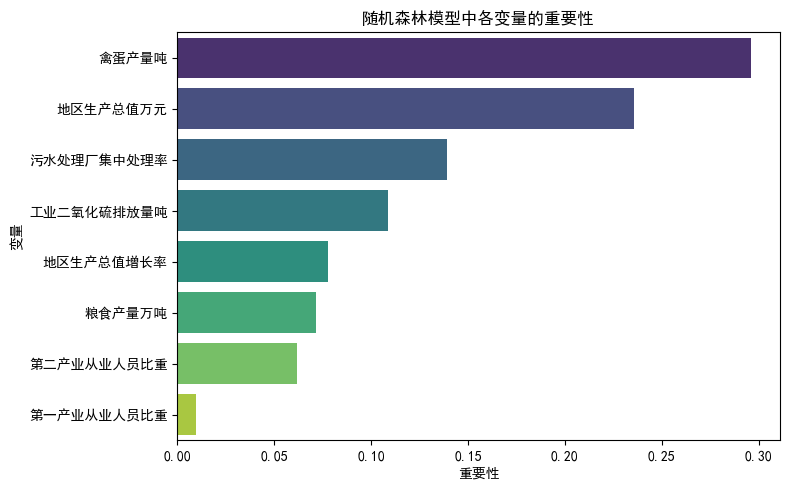

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 设置变量
dependent_var = df.columns[2]  # 请替换为你的目标列名
independent_vars = ['工业二氧化硫排放量吨', '禽蛋产量吨',  '粮食产量万吨','地区生产总值万元','污水处理厂集中处理率', '第二产业从业人员比重', '第一产业从业人员比重','地区生产总值增长率']  # 替换为你的列名

# 2. 预处理数据
rf_df = df[[dependent_var] + independent_vars].dropna()
rf_df = rf_df.apply(pd.to_numeric, errors='coerce').dropna()

X = rf_df[independent_vars]
y = rf_df[dependent_var]

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 建立随机森林模型并训练
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. 模型预测与评估
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"随机森林回归模型评估：\nMSE: {mse:.4f}, R²: {r2:.4f}")

# 6. 可视化：变量重要性
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    '变量': independent_vars,
    '重要性': importances
}).sort_values(by='重要性', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='重要性', y='变量', palette='viridis')
plt.title('随机森林模型中各变量的重要性')
plt.tight_layout()
plt.show()
